In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy swifter shap
!pip install flow_vis

     |████████████████████████████████| 564 kB 34.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import random
import pandas as pd
from time import sleep
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import mediapy as media
from google.colab.patches import cv2_imshow
import mediapy as media
import flow_vis
import swifter
from sklearn.metrics import classification_report
from IPython.display import clear_output 
import shap


In [ ]:
# Create target directory & all intermediate directories if don't exists
def create_dir(dirName):
  try:
      os.makedirs(dirName)    
      print("Directory " , dirName ,  " Created ")
  except FileExistsError:
      print("Directory " , dirName ,  " already exists")  

In [ ]:
# Paths base
PATH_BASE = '/content/drive/MyDrive/ucf_experiments/'
PATH_CICLE = PATH_BASE + 'ciclo_experimental_1/'

# Path base de armazenamento dos augmentations
PATH_DATA = PATH_CICLE + 'data/'
PATH_BLUR = PATH_DATA + 'data_blur/'

# Geração de Labels

In [ ]:
def get_label(string):
  if(string.split('/')[-1][:2] == 'fi'):
    return 1
  elif(string.split('/')[-1][:2] == 'no'):
    return 0

## Imports

In [ ]:
import os
import glob
#from nvidia.dali import pipeline_def
#import nvidia.dali.fn as fn
#import nvidia.dali.types as types
#import nvidia.dali.plugin.tf as dali_tf
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf_v1
import logging
import numpy as np
#import cupy as cp
import mediapy
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import cv2
from time import sleep
from time import time

from tensorflow.keras import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv3D
from tensorflow.keras.layers import Reshape, AveragePooling2D 
from tensorflow.keras.layers import Dense, Dropout, Input 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import LSTM, Multiply
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow import optimizers

tf.config.set_soft_device_placement(True)
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'
tf.get_logger().setLevel(logging.ERROR)


from keras.models import Sequential, Input, Model
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation, LeakyReLU, Add, Multiply
from keras.regularizers import l2
from keras.layers.core import Lambda
from keras.layers.core import Lambda
from tensorflow.keras.optimizers import Adam, SGD

## Crop - Sem Mixed Precision

In [ ]:
max_batch_size = 5
NUM_WORKERS=8
EPOCHS=60
BATCH_SIZE=8

N_CLASSES = 2
IMSIZE = (224, 224)
SequenceLength = 64

##STEPS_PER_EPOCH = int(len(train_dataset_list) / BATCH_SIZE)
#VAL_STEPS_PER_EPOCH = int(len(test_dataset_list) / BATCH_SIZE)

#shapes = ((BATCH_SIZE, SequenceLength, IMSIZE[0], IMSIZE[1], 3), (BATCH_SIZE, N_CLASSES))
#dtypes = (tf.float32, tf.float32)

def create_model(continue_training=False, last_checkpoint=0):
  metrics=[
    tf.keras.metrics.Precision(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC()
  ]

  inputs = Input(shape=(SequenceLength, IMSIZE[0], IMSIZE[1], 3))

  #####################################################
  rgb = inputs
  rgb = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  #####################################################
  x = MaxPooling3D(pool_size=(8,1,1))(rgb)

  #####################################################
  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,3,3))(x)

  #####################################################
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  pred = Dense(N_CLASSES, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=pred)

  sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

  return model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from keras.utils import np_utils
import mediapy as media

class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    Note:
        If you want to load file with other data format, please fix the method of "load_data" as you want
    """
    def __init__(self, input_file, batch_size=1, shuffle=True, data_augmentation=True, uniform_sample=False):
        # Initialize the params
        self.batch_size = batch_size
        self.input_file = input_file
        self.classes = 2
        self.shuffle = shuffle
        self.data_aug = data_augmentation
        self.uniform_sample = uniform_sample
        # Load all the save_path of files, and create a dictionary that save the pair of "data:label"
        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
        
    def search_data_v2(self):
        X_path = []
        Y_dict = {}

        df_videos = pd.read_csv(self.input_file, header=None, sep=';', names=['video_path', 'label'])

        X_path = df_videos[['video_path', 'label']].video_path.to_list()
        Y_dict = pd.get_dummies(df_videos[['video_path', 'label']], columns=['label']).set_index('video_path').T.to_dict(orient="list")

        return X_path, Y_dict

    def search_data(self):
        X_path = []
        Y_dict = {}
        one_hots = np_utils.to_categorical(range(self.classes))

        with open(self.input_file, 'r') as data_file:
           for line in data_file:
             try:
                line = line.rstrip('\n').split(';')
                path = line[0]
                label = int(line[1])
                X_path.append(path)
                Y_dict[path] = one_hots[label]
             except:
               print(line)
              
        return X_path, Y_dict
    
    def print_stats(self):
        # calculate basic information
        self.n_files = len(self.X_path)
        self.n_classes = self.classes
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        # Output states
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(range(self.classes)):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        # get the indexs of each batch
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # using batch_indexs to get path of current batch
        batch_path = [self.X_path[k] for k in batch_indexs]
        # get batch data
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        # shuffle the data at each end of epoch
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        # load data into memory, you can change the np.load to any method you want
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]
        # transfer the data format and take one-hot coding for labels
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        # get total frames of input video and calculate sampling interval 
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        # init empty list for sampled video and 
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        # calculate numer of padded frames and fix it 
        num_pad = target_frames - len(sampled_video)
        if num_pad>0:
            padding = [video[i] for i in range(-num_pad,0)]
            sampled_video += padding     
        # get sampled video

        #sampled_video = tf.image.resize(sampled_video, [224,224])
        return np.array(sampled_video, dtype=np.float32)
    
    def dynamic_crop(self, video):
        # extract layer of optical flow from video
        opt_flows = video[...,3]
        # sum of optical flow magnitude of individual frame
        magnitude = np.sum(opt_flows, axis=0)
        # filter slight noise by threshold 
        thresh = np.mean(magnitude)
        magnitude[magnitude<thresh] = 0
        # calculate center of gravity of magnitude map and adding 0.001 to avoid empty value
        x_pdf = np.sum(magnitude, axis=1) + 0.001
        y_pdf = np.sum(magnitude, axis=0) + 0.001
        # normalize PDF of x and y so that the sum of probs = 1
        x_pdf /= np.sum(x_pdf)
        y_pdf /= np.sum(y_pdf)
        # randomly choose some candidates for x and y 
        x_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=x_pdf)
        y_points = np.random.choice(a=np.arange(224), size=10, replace=True, p=y_pdf)
        # get the mean of x and y coordinates for better robustness
        x = int(np.mean(x_points))
        y = int(np.mean(y_points))
        # avoid to beyond boundaries of array
        x = max(56,min(x,167))
        y = max(56,min(y,167))
        # get cropped video 
        return video[:,x-56:x+56,y-56:y+56,:]  
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        data = media.read_video(path)[...,:3]
        # data = np.float32(data)
        # sampling 64 frames uniformly from the entire video

        if self.uniform_sample:
          data = self.uniform_sampling(video=data, target_frames=64)
        # else:
        #   data = np.array(data, dtype=np.float32)

        # whether to utilize the data augmentation
        if  self.data_aug:
            data = self.color_jitter(data)
            data = self.random_flip(data, prob=0.5)
        # normalize

        # data = self.normalize(data)
        return data, path

In [ ]:
df_rwf = DataGenerator(input_file=PATH_BLUR + 'test_uniform_sample_rwf2000.txt',
                                batch_size=BATCH_SIZE, 
                                data_augmentation=False,
                                uniform_sample=False)
df_rwf

Found 400 files belonging to 2 classes.
         0 :  0
         1 :  1


In [ ]:
sample = next(iter(df_rwf))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
media.show_images(sample[0][:, 0][:3])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def generate_predicts(data, model, path_weights, name_csv):
  df_results = pd.DataFrame()

  with tf.device("/gpu:0"):
    model = model
    model.load_weights(path_weights)
    
    for idx, payload in tqdm(enumerate(data)):

      items, labels = payload
      videos = np.array(items[:, 0].tolist())
      paths =  items[:, 1]
      predictions = model.predict_on_batch(videos)
      K.clear_session()

      batch = {
          'video': paths,
          'predictions':np.argmax(predictions, axis=1),
          'true':np.argmax(labels, axis=1)
      }

      _temp = pd.DataFrame(batch)

      df_results = df_results.append(_temp, ignore_index=True)
      if idx % 100 == 0:
        print(idx)
        
      if idx == 1000:
        break

  df_results.to_csv(PATH_DATA + name_csv)

  report = classification_report(y_pred = df_results['predictions'], y_true=df_results['true'])

  return df_results, report

## Crop - Com Mixed Precision

In [ ]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [ ]:
max_batch_size = 5
NUM_WORKERS=8
EPOCHS=60
BATCH_SIZE=8

N_CLASSES = 2
IMSIZE = (224, 224)
SequenceLength = 64

def create_model2(continue_training=False, last_checkpoint=0):
  metrics=[
    tf.keras.metrics.Precision(),
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC()
  ]

  inputs = Input(shape=(SequenceLength, IMSIZE[0], IMSIZE[1], 3))

  #####################################################
  rgb = inputs
  rgb = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  rgb = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(rgb)
  rgb = MaxPooling3D(pool_size=(1,2,2))(rgb)

  #####################################################
  x = MaxPooling3D(pool_size=(8,1,1))(rgb)

  #####################################################
  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = Conv3D(
      128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = MaxPooling3D(pool_size=(2,3,3))(x)

  #####################################################
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation='relu')(x)
  pred = Dense(N_CLASSES, activation='softmax', dtype='float32')(x)
  model = Model(inputs=inputs, outputs=pred)

  sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

  return model

### The Best Epoch

## Blur - Com Mixed Precision

### The Best Epoch

In [ ]:
best_epoch = 20
base = 'Peliculas_WithNames_'
name_csv = 'Predicts-'+base+'-vBlur-epoch-{}.csv'.format(str(best_epoch))
path_weights = '/content/drive/MyDrive/ucf_experiments/ciclo_experimental_1/data/data_blur/model mixed precision - rwf/checkpoints/model.{}.h5'.format(str(best_epoch))
df_results, report = generate_predicts(df_rwf, create_model2(), path_weights, name_csv)
display(df_results.head(3))
print(report)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
1it [00:03,  3.35s/it]

0


50it [02:33,  3.07s/it]


,video,predictions,true
0,/content/drive/MyDrive/ucf_experiments/ciclo_e...,1,1
1,/content/drive/MyDrive/ucf_experiments/ciclo_e...,0,0
2,/content/drive/MyDrive/ucf_experiments/ciclo_e...,1,1


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       200
           1       0.88      0.76      0.81       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



## Load Data

In [ ]:
epoch_20_predictions = pd.read_csv('/content/drive/MyDrive/ucf_experiments/ciclo_experimental_1/data/Predicts-Peliculas_WithNames_-vBlur-epoch-20.csv')

FileNotFoundError: ignored

In [ ]:
wrong_preds = epoch_20_predictions.loc[epoch_20_predictions.true != epoch_20_predictions.predictions]

In [ ]:
wrong_preds.loc[(wrong_preds.predictions == 1), 'pred_type'] = 'false_positive'
wrong_preds.loc[(wrong_preds.predictions == 0), 'pred_type'] = 'false_negative'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


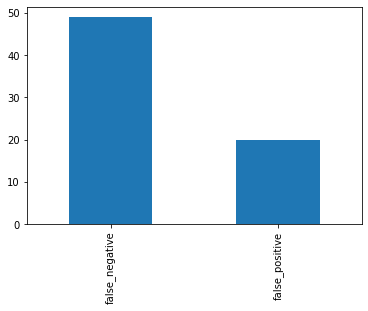

In [ ]:
wrong_preds.pred_type.value_counts().plot.bar()

In [ ]:
samples_fn = wrong_preds.loc[wrong_preds.pred_type == 'false_negative'].sample(15, random_state=42)
samples_fp = wrong_preds.loc[wrong_preds.pred_type == 'false_positive'].sample(15, random_state=42)

wrong_preds_sample = pd.concat([samples_fn, samples_fp])

videos_map = wrong_preds_sample[['video', 'pred_type']].to_dict(orient='records')

In [ ]:
loaded_videos_map = {}

for video_map in videos_map:

  video_name = video_map['video'].split('/')[-1]
  pred_name = video_map['pred_type']
  key_name = f'{video_name}_{pred_name}'

  loaded_videos_map[key_name] = media.read_video(video_map['video'])

In [ ]:
media.show_videos(loaded_videos_map, columns=10)

In [ ]:
from time import sleep

final_df = pd.DataFrame()

commands = {
    '1': 'crowd',
    '2': 'wrong_placed_gauss_mask',
    '3': 'abrupt_movements',
    '4': 'low_quality',
    '5': 'unknown',
    '6': 'other'
}

for idx, row in wrong_preds.sample(30, random_state=42).iterrows():
  video = media.read_video(row['video'])
  print(f'Error: {row["pred_type"]}')
  print(f'Prediction: {row["predictions"]}, Truth: {row["true"]}')

  media.show_video(video)
  print("""
    1 - crowd
    2 - wrong_placed_gauss_mask
    3 - abrupt_movements
    4 - low_quality
    5 - unknown
    6 - other 
    -1 - Exit
  """)
  sleep(2)
  obs = input('Observação: ')
  
  if obs == '-1':
    break

  row['obs'] = commands[obs]

  final_df = final_df.append(row)

  print()
  clear_output()

final_df.to_csv('/content/drive/MyDrive/ucf_experiments/ciclo_experimental_1/error_analysis/wrong_preds_rwf.csv')

In [ ]:
path_weights = '/content/drive/MyDrive/ucf_experiments/ciclo_experimental_1/data/data_blur/model mixed precision - rwf/checkpoints/model.{}.h5'.format(str(20))

with tf.device("/gpu:0"):
  model = create_model2()
  model.load_weights(path_weights)